In [3]:
#!pip install Prophet
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


,ACF_AR(2),PACF_AR(2)
0,1.000000,1.000000
1,0.518614,0.518960
2,-0.385766,-0.897246
3,-0.850774,-0.045730
4,-0.499951,-0.016774
5,0.264949,-0.021704
6,0.716555,0.037779
7,0.487823,0.055682
8,-0.145301,0.032721
9,-0.581757,0.004227


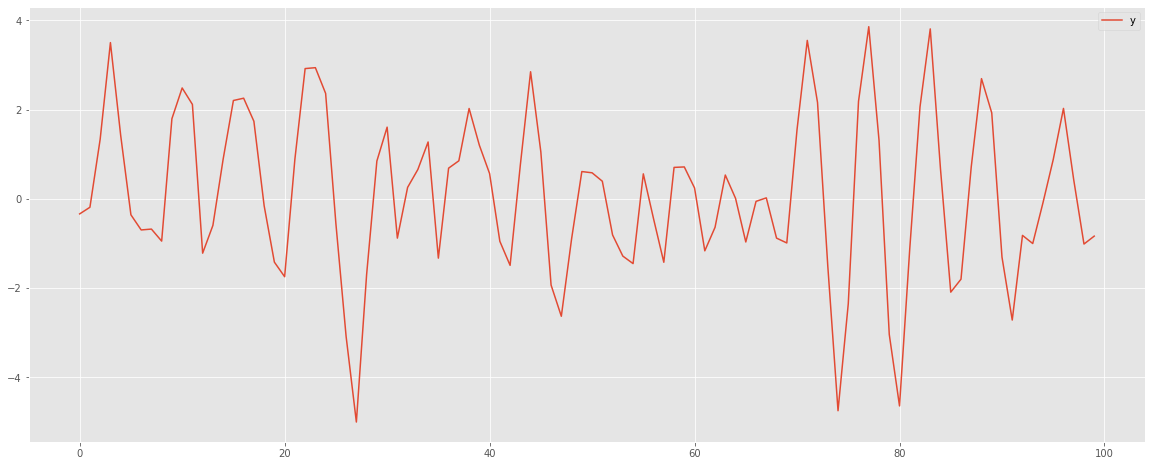

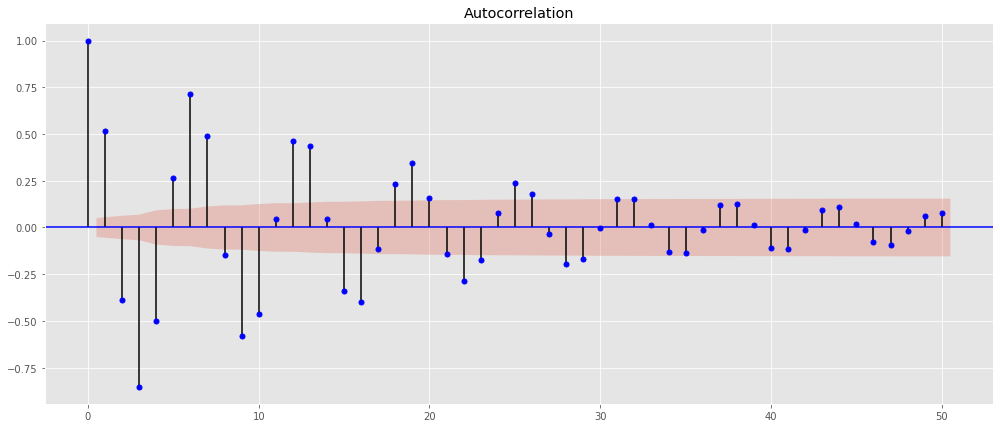

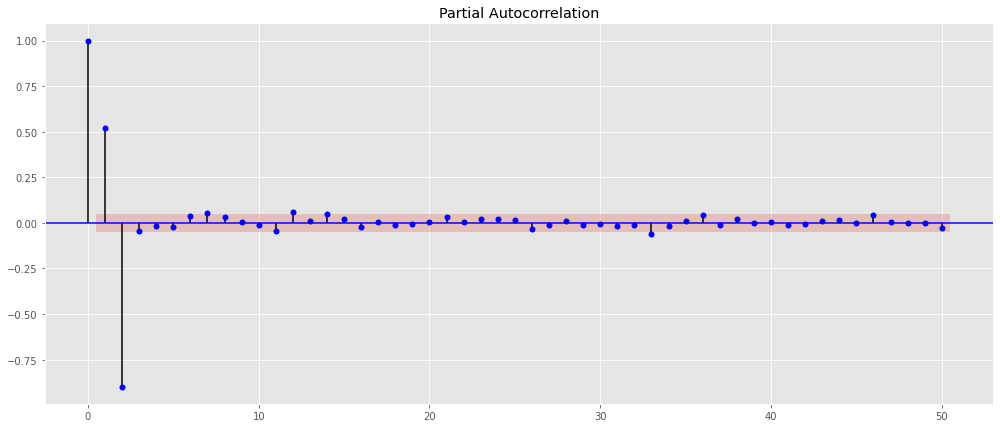

In [8]:
n=1500
lags=50
arparams = np.array([1, -0.9])
maparams = np.array([0.0])
ar = np.r_[1, -arparams]
ma = np.r_[1, maparams]

exogen='y'
Xt = sm.tsa.arma_generate_sample(ar, ma, n,)
series_df = pd.DataFrame(Xt,columns= [exogen])
ar_cfs = pd.DataFrame([acf(series_df[exogen],nlags=lags),pacf(series_df[exogen],nlags=lags)])\
             .transpose()
ar_cfs.columns = ['ACF_AR(2)','PACF_AR(2)']
display(ar_cfs[:10])

plt.style.use('ggplot')
series_df.head(100).plot(figsize=(20,8))
plt.figsize=(15,10)
fig = plot_acf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
fig = plot_pacf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show()

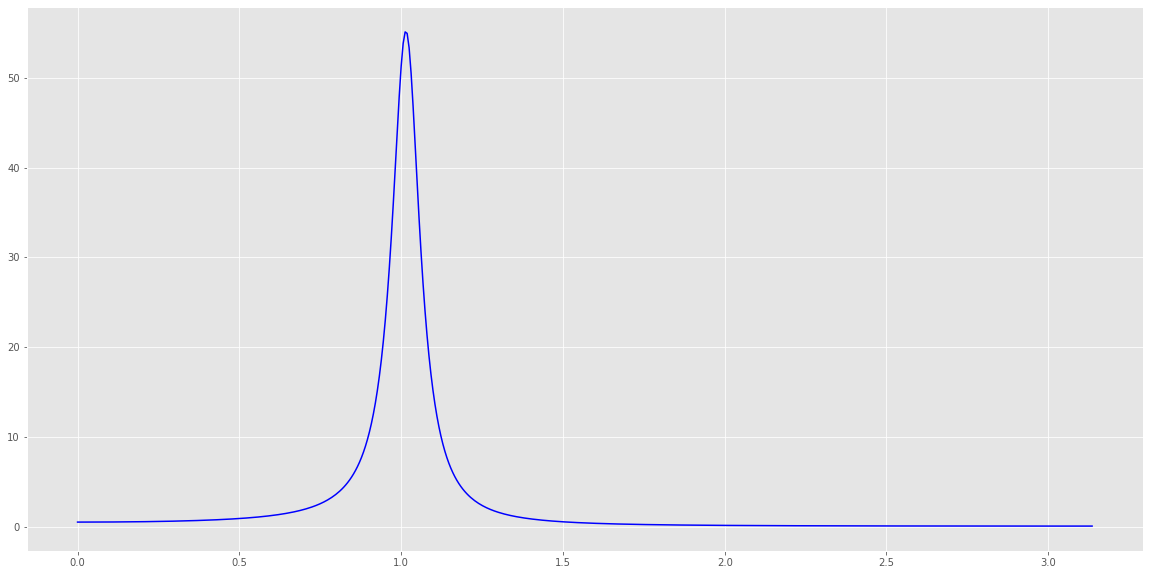

In [9]:
from statsmodels.tsa.arima_process import arma_periodogram

freqs, density = arma_periodogram(ar, ma)
df_fw = pd.DataFrame([freqs, density]).transpose()
df_fw.columns = ['Freqs(w)','fs(w)']
plt.figure(figsize=(20,10))
plt.plot(df_fw['Freqs(w)'],df_fw['fs(w)'],color='Blue')

,Freqs(w),fs_est(w),Periodo
242,0.161333,924.842928,6.198347
241,0.160667,490.383166,6.224066
236,0.157333,452.294093,6.355932
222,0.148000,384.878222,6.756757
245,0.163333,354.202737,6.122449
255,0.170000,347.623388,5.882353
246,0.164000,342.406702,6.097561
240,0.160000,318.515590,6.250000
254,0.169333,300.658105,5.905512
235,0.156667,292.019446,6.382979


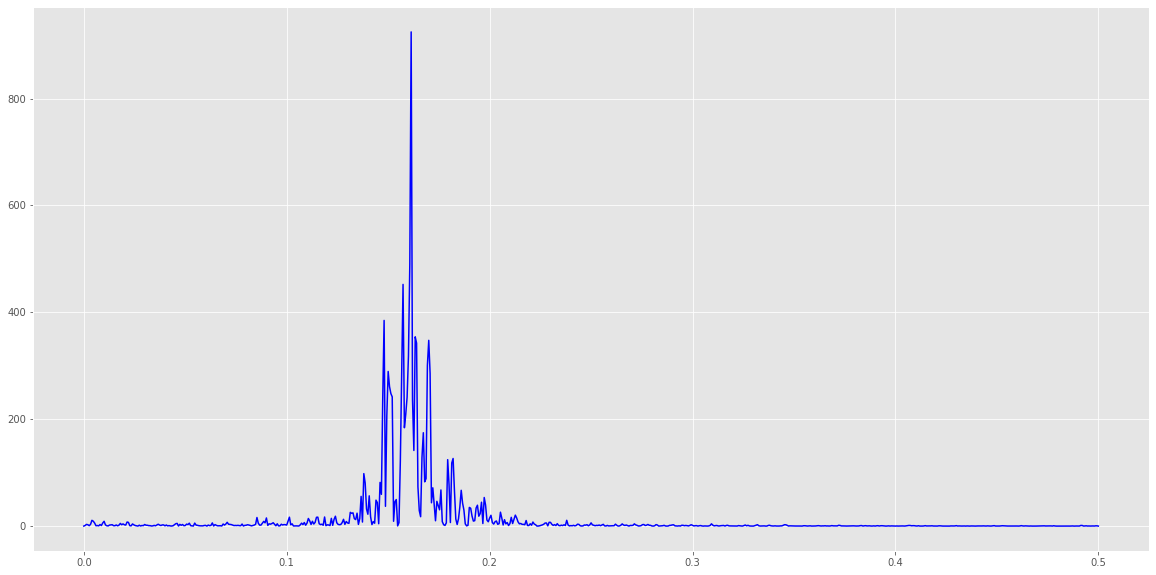

In [11]:
from scipy import signal

freqs, density_est = signal.periodogram(x=series_df[exogen], scaling='density', window='hamming')
df_fw_est = pd.DataFrame([freqs, density_est]).transpose()
df_fw_est.columns = ['Freqs(w)','fs_est(w)']
plt.figure(figsize=(20,10))
plt.plot(df_fw_est['Freqs(w)'],df_fw_est['fs_est(w)'],color='Blue')
df_fw_est['Periodo'] = 1/df_fw_est['Freqs(w)']
df_fw_est = df_fw_est.sort_values('fs_est(w)',ascending=False)
df_fw_est.head(15)

In [15]:
prophet_series_df = series_df.copy()
prophet_series_df['ds'] = pd.date_range(start='2010-01-01', periods=len(prophet_series_df))
display(prophet_series_df)
prophet_model = Prophet()\
  .add_seasonality('componente_1', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[0], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_2', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[1], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_3', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[2], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_4', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[3], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_5', 
                   period=1/
                   df_fw_est['Freqs(w)'].values[4], 
                   fourier_order=20, 
                   mode='additive')\
  .fit(prophet_series_df)

,y,ds
0,-0.335738,2010-01-01
1,-0.187147,2010-01-02
2,1.338871,2010-01-03
3,3.504067,2010-01-04
4,1.426651,2010-01-05
...,...,...
1495,-2.265910,2014-02-04
1496,0.357814,2014-02-05
1497,2.322522,2014-02-06
1498,0.453925,2014-02-07


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
prophet_series_df = series_df.copy()
prophet_series_df['ds'] = pd.date_range(start='2010-01-01', periods=len(prophet_series_df))
display(prophet_series_df)

prophet_model = Prophet()\
  .add_seasonality('componente_1', 
                   period=df_fw_est['Periodo'].values[0], 
                   fourier_order=20, 
                   mode='additive')\
    .fit(prophet_series_df)

,y,ds
0,-0.335738,2010-01-01
1,-0.187147,2010-01-02
2,1.338871,2010-01-03
3,3.504067,2010-01-04
4,1.426651,2010-01-05
...,...,...
1495,-2.265910,2014-02-04
1496,0.357814,2014-02-05
1497,2.322522,2014-02-06
1498,0.453925,2014-02-07


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
prophet_prdiction_df = pd.DataFrame(pd.date_range(start='2010-01-01', 
                                    periods=len(prophet_series_df)+30),
                                    columns=['ds'])

prophet_prdiction_df = pd.concat([prophet_model.predict(prophet_prdiction_df), series_df[['y']]],axis=1)\
                         .set_index('ds')
prophet_prdiction_df

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,componente_1,componente_1_lower,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2010-01-01,0.039469,-4.078453,1.909422,0.039469,0.039469,-1.210636,-1.210636,-1.210636,-0.111686,-0.111686,...,-0.104889,-0.104889,0.137861,0.137861,0.137861,0.0,0.0,0.0,-1.171167,-0.335738
2010-01-02,0.039417,-3.523868,2.430292,0.039417,0.039417,-0.681696,-0.681696,-0.681696,-0.955378,-0.955378,...,0.145773,0.145773,0.156026,0.156026,0.156026,0.0,0.0,0.0,-0.642279,-0.187147
2010-01-03,0.039366,-2.493697,3.485366,0.039366,0.039366,0.519537,0.519537,0.519537,-0.886824,-0.886824,...,0.242886,0.242886,0.171486,0.171486,0.171486,0.0,0.0,0.0,0.558903,1.338871
2010-01-04,0.039315,-1.143909,4.756762,0.039315,0.039315,1.849191,1.849191,1.849191,0.115036,0.115036,...,0.115794,0.115794,0.184211,0.184211,0.184211,0.0,0.0,0.0,1.888506,3.504067
2010-01-05,0.039263,-1.617683,4.232662,0.039263,0.039263,1.200325,1.200325,1.200325,0.949274,0.949274,...,-0.042142,-0.042142,0.194247,0.194247,0.194247,0.0,0.0,0.0,1.239588,1.426651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-06,-0.037987,-5.004151,0.941164,-0.037988,-0.037987,-1.963803,-1.963803,-1.963803,-0.299015,-0.299015,...,-0.248438,-0.248438,-0.042720,-0.042720,-0.042720,0.0,0.0,0.0,-2.001790,NaN
2014-03-07,-0.038038,-5.517436,0.133653,-0.038038,-0.038038,-2.485542,-2.485542,-2.485542,-0.875633,-0.875633,...,-0.104889,-0.104889,-0.043120,-0.043120,-0.043120,0.0,0.0,0.0,-2.523580,NaN
2014-03-08,-0.038089,-4.154939,1.925780,-0.038089,-0.038088,-0.928885,-0.928885,-0.928885,-0.567508,-0.567508,...,0.145773,0.145773,-0.042719,-0.042719,-0.042719,0.0,0.0,0.0,-0.966974,NaN


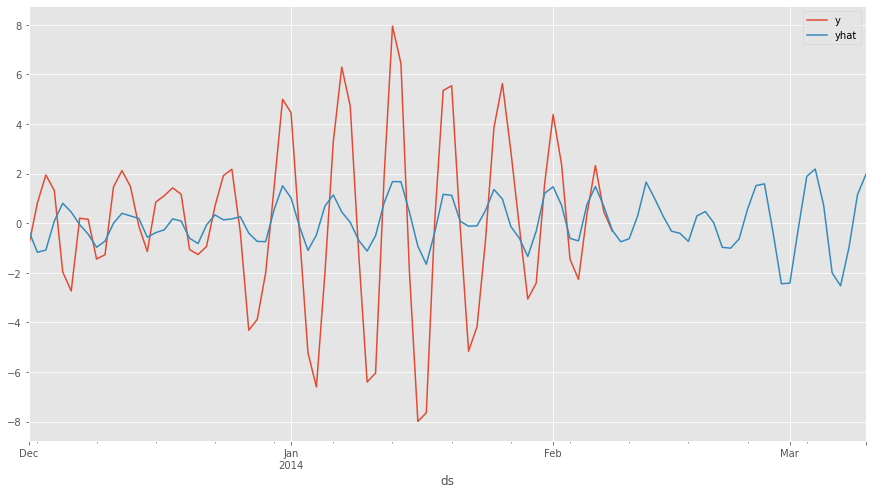

In [17]:
prophet_prdiction_df.tail(100)[['y', 'yhat',]].plot(figsize=(15,8))

In [21]:
citytemp_df

,index,Region,Country,State,City,Month,Day,Year,AvgTemperature,ds,y
0,1212930,North America,Mexico,NaN,Mexico City,01,01,1995,57.7,1995-01-01,14.277778
1,1212931,North America,Mexico,NaN,Mexico City,01,02,1995,56.1,1995-01-02,13.388889
2,1212932,North America,Mexico,NaN,Mexico City,01,03,1995,57.6,1995-01-03,14.222222
3,1212933,North America,Mexico,NaN,Mexico City,01,04,1995,57.3,1995-01-04,14.055556
4,1212934,North America,Mexico,NaN,Mexico City,01,05,1995,58.8,1995-01-05,14.888889
...,...,...,...,...,...,...,...,...,...,...,...
9260,1222190,North America,Mexico,NaN,Mexico City,05,08,2020,63.7,2020-05-08,17.611111
9261,1222191,North America,Mexico,NaN,Mexico City,05,09,2020,65.6,2020-05-09,18.666667
9262,1222192,North America,Mexico,NaN,Mexico City,05,10,2020,63.6,2020-05-10,17.555556
9263,1222193,North America,Mexico,NaN,Mexico City,05,11,2020,62.8,2020-05-11,17.111111


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ds,y
0,1995-01-01,14.277778
1,1995-01-02,13.388889
2,1995-01-03,14.222222
3,1995-01-04,14.055556
4,1995-01-05,14.888889
...,...,...
9260,2020-05-08,17.611111
9261,2020-05-09,18.666667
9262,2020-05-10,17.555556
9263,2020-05-11,17.111111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


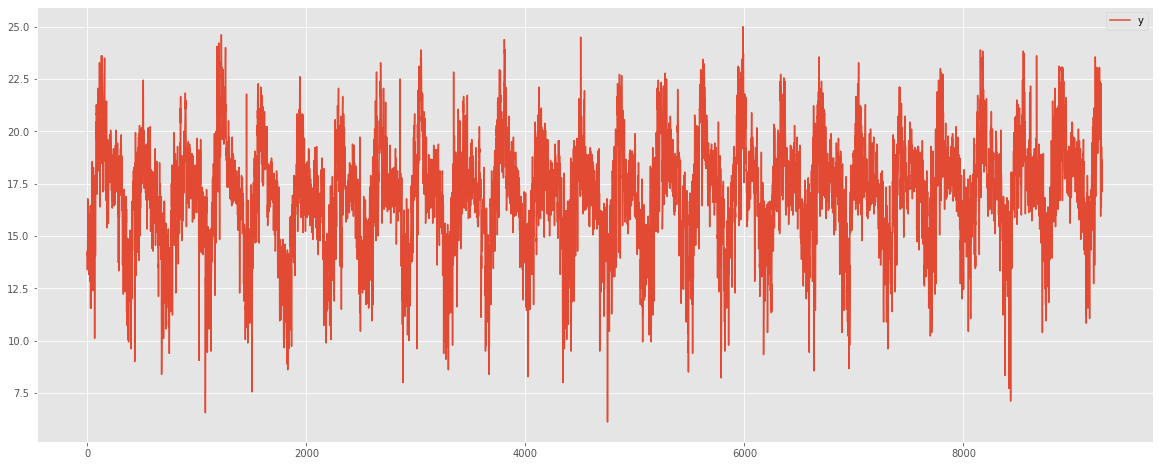

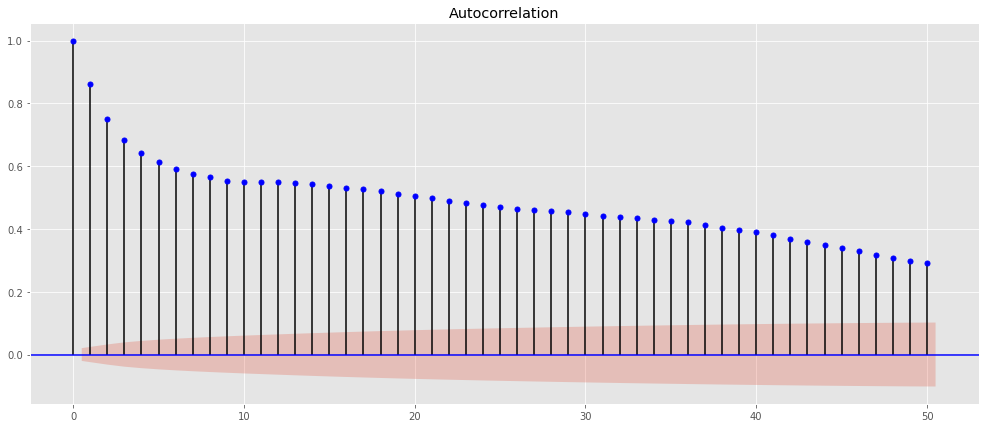

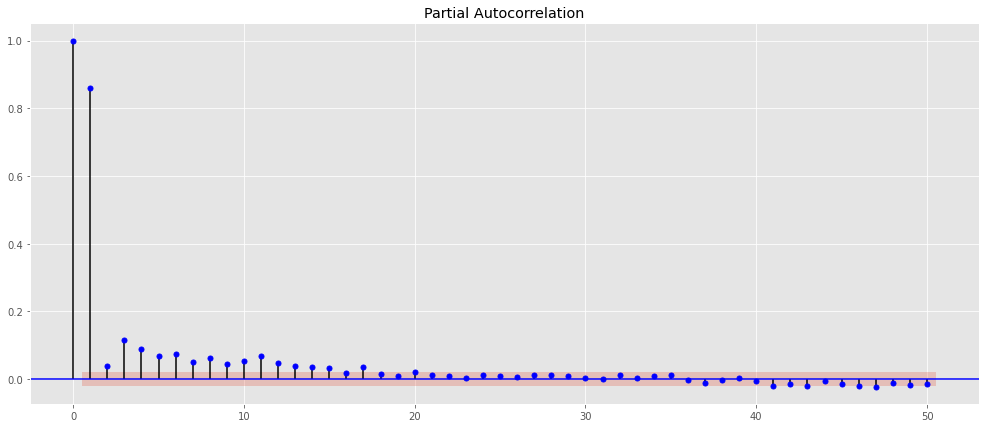

In [19]:
temperatures_df = pd.read_csv('city_temperature.csv')
citytemp_df = temperatures_df[(temperatures_df['Country']=='Mexico') &\
                              (temperatures_df['City']=='Mexico City')].copy().reset_index()
                              
citytemp_df['Year'] = citytemp_df['Year'].apply(lambda row: str(row))
citytemp_df['Month'] = citytemp_df['Month'].apply(lambda row: str(row).zfill(2))
citytemp_df['Day'] = citytemp_df['Day'].apply(lambda row: str(row).zfill(2))
citytemp_df['ds'] = citytemp_df['Year']+'-'+citytemp_df['Month']+'-'+citytemp_df['Day']
citytemp_df['y'] = (5/9)*(citytemp_df['AvgTemperature']-32).copy()
series_df = citytemp_df[['ds','y']]
display(series_df)
series_df['y'] = np.where(series_df['y']<=-10, series_df['y'].mean(), series_df['y'])
series_df.plot(figsize=(20,8))
plt.figsize=(15,10)
fig = plot_acf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
fig = plot_pacf(series_df[exogen],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(7)
plt.show()

,Freqs(w),fs_est(w),Periodo
25,0.002698,15549.436399,370.600000
26,0.002806,10415.826143,356.346154
51,0.005505,3445.683353,181.666667
50,0.005397,1628.869252,185.300000
24,0.002590,687.323915,386.041667
1,0.000108,446.200449,9265.000000
27,0.002914,203.016271,343.148148
7,0.000756,201.096059,1323.571429
165,0.017809,150.963341,56.151515
4,0.000432,150.573533,2316.250000


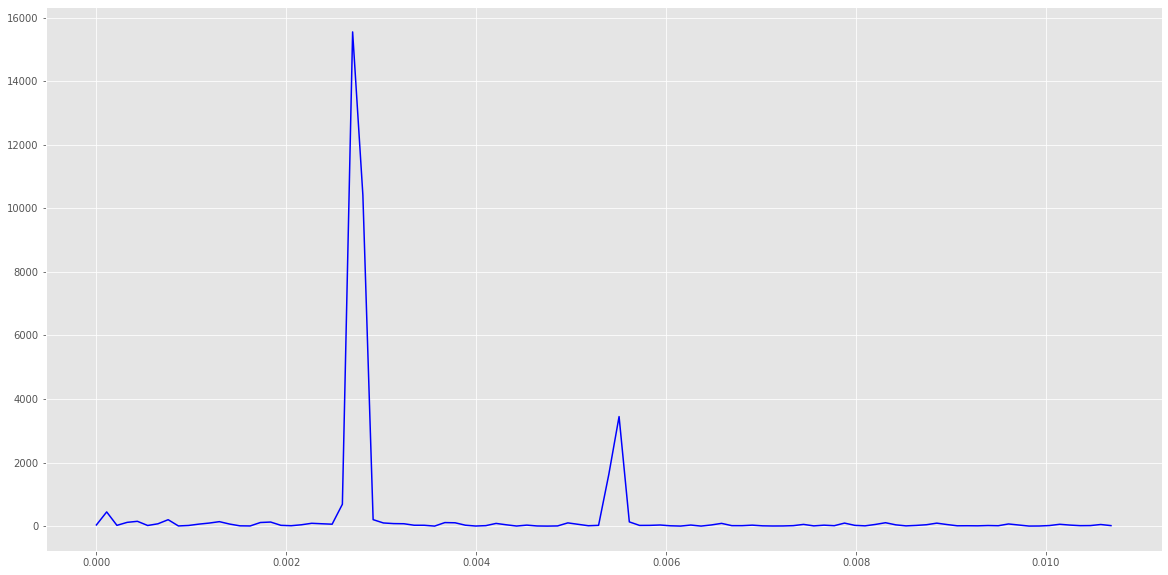

In [22]:
from scipy import signal

freqs, density_est = signal.periodogram(x=series_df[exogen], scaling='density', window='hamming')
df_fw_est = pd.DataFrame([freqs, density_est]).transpose()
df_fw_est.columns = ['Freqs(w)','fs_est(w)']
plt.figure(figsize=(20,10))
plt.plot(df_fw_est['Freqs(w)'].head(100),df_fw_est['fs_est(w)'].head(100),color='Blue')
df_fw_est['Periodo'] = 1/df_fw_est['Freqs(w)']
df_fw_est = df_fw_est.sort_values('fs_est(w)',ascending=False)
df_fw_est.head(30)

In [23]:
prophet_series_df = series_df.copy()
prophet_series_df['ds'] = pd.date_range(start=series_df['ds'][0], periods=len(prophet_series_df))

prophet_model = Prophet()\
  .add_seasonality('componente_1', 
                   period=df_fw_est['Periodo'][0], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_2', 
                   period=df_fw_est['Periodo'][1], 
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_3', 
                   period=df_fw_est['Periodo'][3],
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_4', 
                   period=df_fw_est['Periodo'][4],
                   fourier_order=20, 
                   mode='additive')\
  .add_seasonality('componente_5', 
                   period=df_fw_est['Periodo'][5],
                   fourier_order=20, 
                   mode='additive')\
  .fit(prophet_series_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
prophet_prdiction_df = pd.DataFrame(pd.date_range(start=series_df['ds'][0], periods=len(prophet_series_df)+365),
                                    columns=['ds'])

display(prophet_prdiction_df)

prophet_prdiction_df = pd.concat([prophet_model.predict(prophet_prdiction_df), series_df[['y']]],axis=1)\
                         .set_index('ds')
prophet_prdiction_df

,ds
0,1995-01-01
1,1995-01-02
2,1995-01-03
3,1995-01-04
4,1995-01-05
...,...
9625,2021-05-09
9626,2021-05-10
9627,2021-05-11
9628,2021-05-12


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,componente_1,componente_1_lower,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
1995-01-01,14.375898,11.334095,15.461300,14.375898,14.375898,-0.935477,-0.935477,-0.935477,2.05087,2.05087,...,-0.050955,-0.050955,-2.211051,-2.211051,-2.211051,0.0,0.0,0.0,13.440421,14.277778
1995-01-02,14.376029,11.299942,15.380789,14.376029,14.376029,-0.937367,-0.937367,-0.937367,2.05087,2.05087,...,-0.024510,-0.024510,-2.199789,-2.199789,-2.199789,0.0,0.0,0.0,13.438662,13.388889
1995-01-03,14.376159,11.462113,15.519810,14.376159,14.376159,-0.964461,-0.964461,-0.964461,2.05087,2.05087,...,-0.025821,-0.025821,-2.188089,-2.188089,-2.188089,0.0,0.0,0.0,13.411698,14.222222
1995-01-04,14.376289,11.235154,15.394528,14.376289,14.376289,-0.962424,-0.962424,-0.962424,2.05087,2.05087,...,-0.000677,-0.000677,-2.175896,-2.175896,-2.175896,0.0,0.0,0.0,13.413865,14.055556
1995-01-05,14.376419,11.381612,15.614646,14.376419,14.376419,-0.949375,-0.949375,-0.949375,2.05087,2.05087,...,0.032707,0.032707,-2.163176,-2.163176,-2.163176,0.0,0.0,0.0,13.427045,14.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-09,15.630094,18.334875,22.633527,15.630094,15.630094,4.789147,4.789147,4.789147,2.05087,2.05087,...,-0.050955,-0.050955,2.936545,2.936545,2.936545,0.0,0.0,0.0,20.419241,NaN
2021-05-10,15.630224,18.257530,22.554848,15.630224,15.630225,4.777493,4.777493,4.777493,2.05087,2.05087,...,-0.024510,-0.024510,2.950482,2.950482,2.950482,0.0,0.0,0.0,20.407717,NaN
2021-05-11,15.630355,18.171705,22.486783,15.630354,15.630355,4.738621,4.738621,4.738621,2.05087,2.05087,...,-0.025821,-0.025821,2.963167,2.963167,2.963167,0.0,0.0,0.0,20.368976,NaN


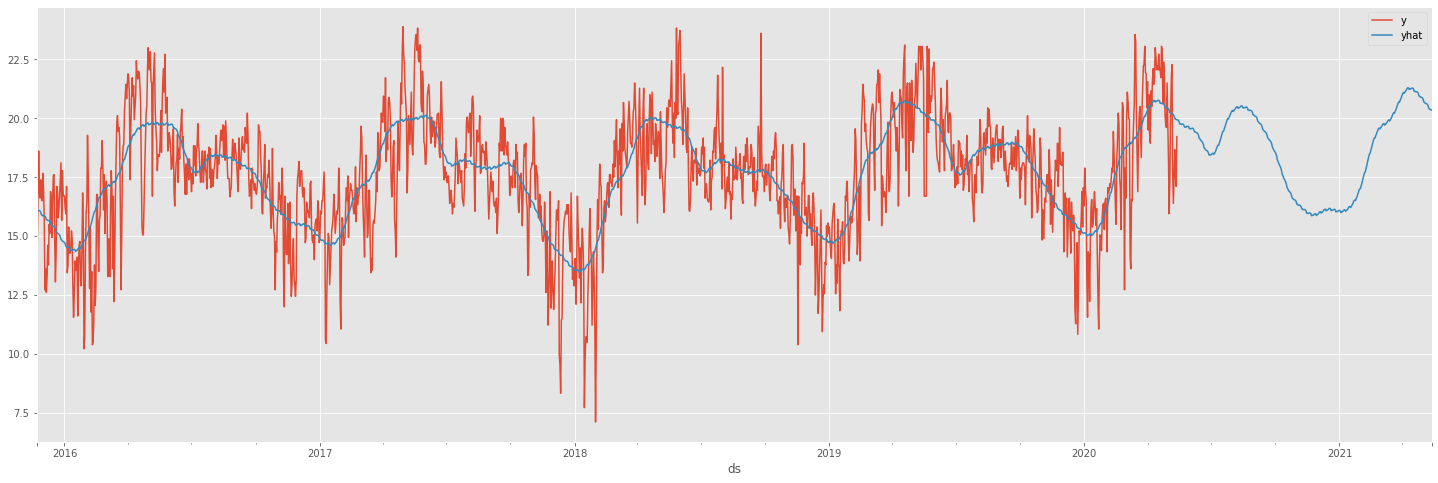

In [29]:
prophet_prdiction_df[['y', 'yhat',]].tail(2000).plot(figsize=(25,8))